In [39]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, optimizers, models
from keras.applications.xception import Xception


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
train_path="/content/Rice Disease Image Dataset/train"
val_path="/content/Rice Disease Image Dataset/validation"
test_path="/content/Rice Disease Image Dataset/test"

In [6]:
names=os.listdir(train_path)
names

['Healthy', 'BrownSpot', 'LeafBlast']

In [40]:
def total_img(path,names):
    count=0
    for name in names:
        size=len(os.listdir(os.path.join(path, name)))
        count+=size
    return count

print("Total Training Images: ", total_img(train_path, names))
print("Total Validation Images: ", total_img(val_path, names))
print("Total Test Images: ", total_img(test_path, names))

Total Training Images:  1248
Total Validation Images:  210
Total Test Images:  90


# Data Pre Processing

# Using ImageDataGenerator to read images from directories

In [56]:
datagenerator=ImageDataGenerator(
                             rescale=1./255,
                            #  rotation_range=40,
                            #  width_shift_range=0.2,
                            #  height_shift_range=0.2,
                            #  zoom_range=0.2,
                            #  shear_range=0.2,
                            #  horizontal_flip=True,
                            #  fill_mode='nearest'
                             )

In [57]:
train_gen= datagenerator.flow_from_directory(
                                              train_path,
                                              batch_size=35,
                                              target_size=(224,224),
                                              class_mode='categorical'
                                            )

Found 1248 images belonging to 3 classes.


In [58]:
val_generator=ImageDataGenerator(rescale=1./255)

In [59]:
val_gen= val_generator.flow_from_directory(
                                            val_path,
                                            target_size=(224,224),
                                            batch_size=20,
                                            class_mode='categorical'
                                        )

Found 210 images belonging to 3 classes.


In [60]:
labels=train_gen.class_indices
labels

{'BrownSpot': 0, 'Healthy': 1, 'LeafBlast': 2}

# Display some Images

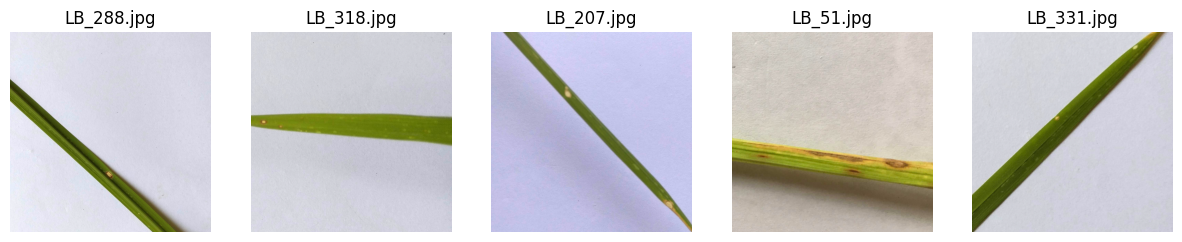

In [61]:
import random
import cv2

# define the directory containing your images
directory = "/content/Rice Disease Image Dataset/train/LeafBlast/"

file_list = os.listdir(directory)

# define the number of images you want to display
num_images = 5

# randomly select the file names for the images you want to display
selected_files = random.sample(file_list, num_images)

# create a subplot for each image and display it
fig, axs = plt.subplots(1, num_images, figsize=(15, 5))

for i, filename in enumerate(selected_files):

    image = cv2.imread(os.path.join(directory, filename))
    # convert the image from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    axs[i].imshow(image)
    axs[i].axis('off')
    axs[i].set_title(filename)

# show the plot
plt.show()

# Pre_trained Xception Model

In [62]:
pre_trained_model=Xception(input_shape=(224,224,3),  include_top=False,  weights='imagenet')

In [63]:
for layer in pre_trained_model.layers:
  layer.trainable=False

In [64]:
pre_trained_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_4[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]

In [65]:
print("Last layer Output Shape: ", pre_trained_model.output_shape)

last_output= pre_trained_model.output

Last layer Output Shape:  (None, 7, 7, 2048)


# Creating Network Architecture

In [66]:
x=layers.Flatten()(last_output)
x=layers.Dense(256, activation='relu')(x)
x=layers.Dropout(0.5)(x)
x=layers.Dense(64, activation='relu')(x)
x=layers.Dropout(0.5)(x)
x=layers.Dense(3, activation='softmax')(x)

model=models.Model(pre_trained_model.input, x)

In [67]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_4[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]'

In [68]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training

In [69]:
history=model.fit(train_gen, epochs=30, validation_data=val_gen)

Epoch 1/30
36/36 [==============================] - 90s 2s/step - loss: 5.6596 - accuracy: 0.4054 - val_loss: 0.9461 - val_accuracy: 0.5524
Epoch 2/30
36/36 [==============================] - 85s 2s/step - loss: 1.6184 - accuracy: 0.4720 - val_loss: 0.8923 - val_accuracy: 0.5714
Epoch 3/30
36/36 [==============================] - 87s 2s/step - loss: 1.0618 - accuracy: 0.4936 - val_loss: 0.8066 - val_accuracy: 0.5714
Epoch 4/30
36/36 [==============================] - 93s 3s/step - loss: 1.0280 - accuracy: 0.5240 - val_loss: 0.8783 - val_accuracy: 0.6810
Epoch 5/30
36/36 [==============================] - 84s 2s/step - loss: 0.9599 - accuracy: 0.5545 - val_loss: 0.8288 - val_accuracy: 0.6667
Epoch 6/30
36/36 [==============================] - 87s 2s/step - loss: 0.9119 - accuracy: 0.5433 - val_loss: 0.8904 - val_accuracy: 0.6190
Epoch 7/30
36/36 [==============================] - 85s 2s/step - loss: 0.9672 - accuracy: 0.5457 - val_loss: 0.8553 - val_accuracy: 0.6571
Epoch 8/30
36/36 [==

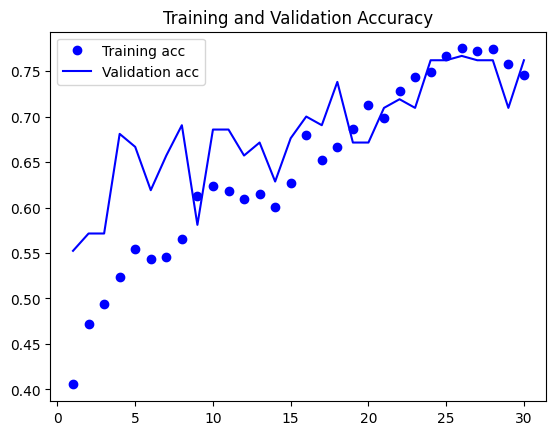

In [70]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

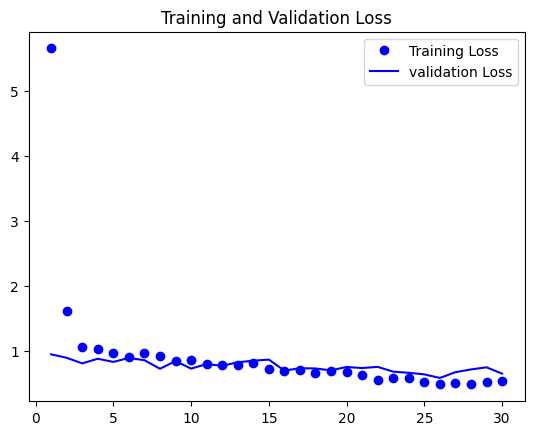

In [71]:
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs= range(1,len(loss)+1)
plt.plot(epochs, loss, 'bo', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [75]:
model.save("/content/drive/MyDrive/Rice_Leaf_Disease_Detection xception Model.h5")
print("Saved model to disk")

Saved model to disk


In [78]:
test_generator=ImageDataGenerator(rescale=1./255)

test_gen= test_generator.flow_from_directory(
                                            test_path,
                                            target_size=(224,224),
                                            batch_size=4,
                                            class_mode='categorical'
                                        )

Found 90 images belonging to 3 classes.


In [79]:
loss, acc= model.evaluate(test_gen)
print("Test Accuracy: ", acc)
print("Test Loss: ", loss)

23/23 [==============================] - 5s 217ms/step - loss: 0.5971 - accuracy: 0.7222
Test Accuracy:  0.7222222089767456
Test Loss:  0.5971463322639465
